Import Library

In [19]:
# Import library utama
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os


Upload Dataset ke Colab

In [2]:
from google.colab import files
import shutil

# Upload folder dataset (misalnya kamu pilih folder utama berisi dua folder gambar)
uploaded = files.upload()

# Jika dataset dikompres (zip), ekstrak dulu
for filename in uploaded.keys():
    if filename.endswith(".zip"):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall("/content/dataset")
        print("Dataset berhasil diekstrak ke /content/dataset")


Saving dataset tanaman herbal.zip to dataset tanaman herbal.zip
Dataset berhasil diekstrak ke /content/dataset


Persiapan Dataset dan Preprocessing

In [11]:
# Lokasi dataset
data_dir = "/content/dataset/dataset tanaman herbal"

# Gunakan ImageDataGenerator untuk augmentasi dan preprocessing MobileNetV2
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,        # 80% train, 20% validation
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 82 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


Membangun Model Transfer Learning (MobileNetV2)

In [12]:
# Load base model dari MobileNetV2 tanpa top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Bekukan layer awal supaya tidak ikut dilatih (feature extractor)
base_model.trainable = False

# Tambahkan layer classifier di atasnya
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Pelatihan Model

In [13]:
# Latih model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.5083 - loss: 1.0058 - val_accuracy: 0.3500 - val_loss: 0.9979
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6016 - loss: 0.7615 - val_accuracy: 0.4500 - val_loss: 0.8064
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6383 - loss: 0.7233 - val_accuracy: 0.5000 - val_loss: 0.7474
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7965 - loss: 0.4234 - val_accuracy: 0.7000 - val_loss: 0.5873
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8031 - loss: 0.4692 - val_accuracy: 0.7500 - val_loss: 0.4775
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8292 - loss: 0.4174 - val_accuracy: 0.7500 - val_loss: 0.4730
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.8967 - loss: 0.2967 - val_accuracy: 0.9000 - val_loss: 0.3615
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8743 - loss: 0.2645 - val_accuracy: 0.9000 - val_loss: 0.3657
Epoch 9/10
3/3

Evaluasi dan Visualisasi Hasil

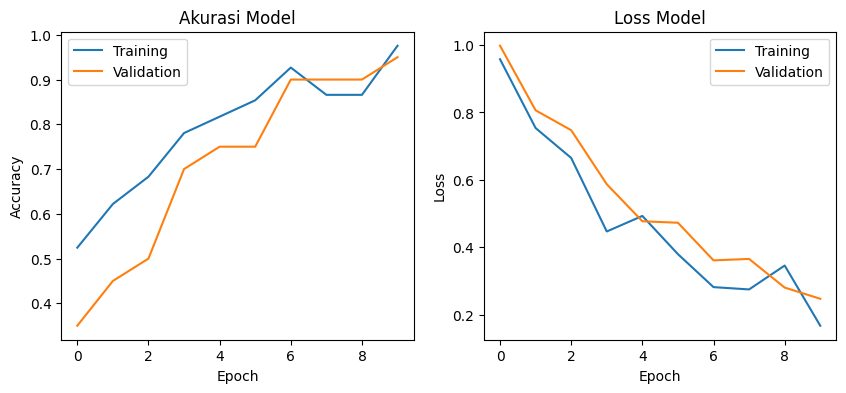

In [14]:
# Plot akurasi dan loss
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Uji Model dengan Gambar Baru

In [15]:
from tensorflow.keras.preprocessing import image

img_path = '/content/dataset/dataset tanaman herbal/Daun Sirih/001.jpg'  # Corrected path
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

pred = model.predict(x)
classes = list(train_generator.class_indices.keys())
print("Prediksi gambar ini adalah:", classes[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediksi gambar ini adalah: Daun Sirih


Fine-Tuning (meningkatkan akurasi)

In [16]:
# Unfreeze sebagian layer akhir
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Compile ulang dengan learning rate kecil
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Lanjutkan training
fine_tune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    verbose=1
)


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.5371 - loss: 0.8705 - val_accuracy: 0.9500 - val_loss: 0.2517
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.6126 - loss: 0.7563 - val_accuracy: 0.9500 - val_loss: 0.2545
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.7348 - loss: 0.4428 - val_accuracy: 0.9500 - val_loss: 0.2558
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.7242 - loss: 0.5087 - val_accuracy: 0.9500 - val_loss: 0.2417
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.7341 - loss: 0.4754 - val_accuracy: 0.8000 - val_loss: 0.3390


Simpan Model

In [17]:
model.save('/content/model_mobilenetv2_herbal.h5')
print("Model tersimpan!")


Model tersimpan!


Uji Model dengan Upload Gambar Langsung

Saving 001.jpg to 001 (1).jpg
Saving 002.jpg to 002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


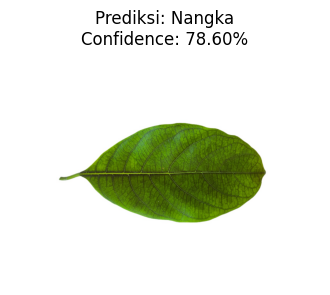

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


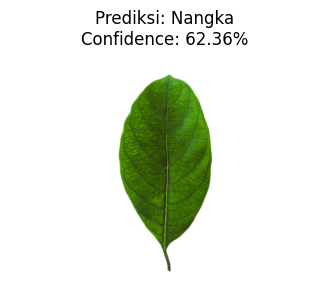

In [21]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Upload satu atau beberapa gambar
uploaded = files.upload()

# Loop untuk setiap gambar yang diupload
for fn in uploaded.keys():
    path = fn

    # Load dan preprocess gambar
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Prediksi dengan model
    pred = model.predict(x)
    classes = list(train_generator.class_indices.keys())
    pred_label = classes[np.argmax(pred)]
    confidence = np.max(pred) * 100  # ambil nilai tertinggi dari probabilitas

    # Tampilkan hasil prediksi
    plt.figure(figsize=(4,4))
    plt.imshow(image.load_img(path))
    plt.axis('off')
    plt.title(f"Prediksi: {pred_label}\nConfidence: {confidence:.2f}%")
    plt.show()


In [23]:
import pandas as pd

results = []

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    pred = model.predict(x)
    classes = list(train_generator.class_indices.keys())
    pred_label = classes[np.argmax(pred)]
    confidence = np.max(pred) * 100

    results.append({'filename': fn, 'predicted_label': pred_label, 'confidence': confidence})

# Simpan hasil prediksi ke file CSV
df = pd.DataFrame(results)
df.to_csv('hasil_prediksi.csv', index=False)
print("Hasil prediksi disimpan ke hasil_prediksi.csv")
df


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Hasil prediksi disimpan ke hasil_prediksi.csv


,filename,predicted_label,confidence
0,001 (1).jpg,Nangka,78.595505
1,002.jpg,Nangka,62.359928


In [24]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1V-1LJjYX98wjGSn-WC8wMEzpV2bdnf87MgAoeUn3MqQ/edit#gid=0
